In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from scipy.stats import norm

data = np.load('formationchannels.npy')

We could have different solutions because it finds a local maximum. If we generate data in principle we could have more extractions

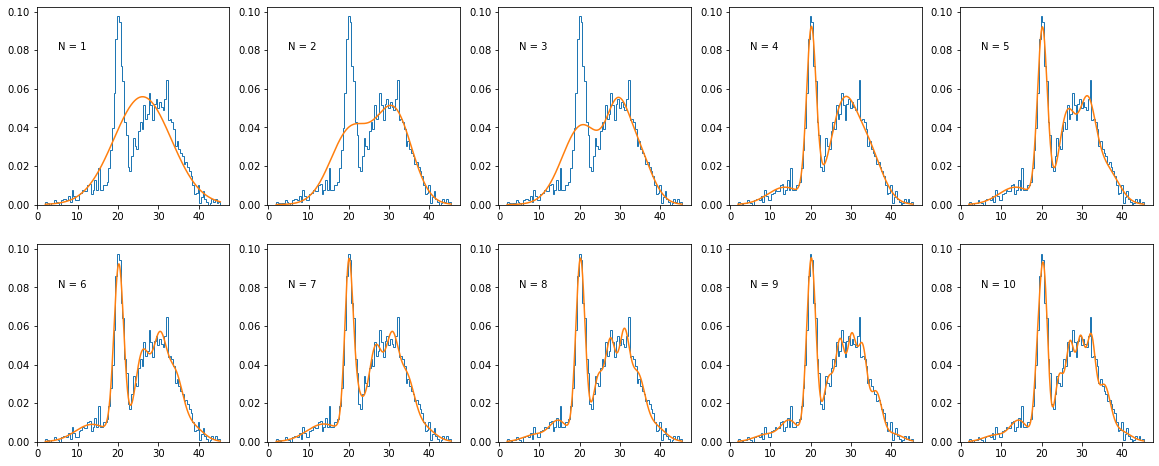

In [2]:
fig, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2,5, figsize=(20,8))
ax = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]

for i in range(0,10):
    ax[i].hist(data[:,0], bins=100, density=True, histtype = 'step')

x_grid = np.linspace(np.min(data[:,0]), np.max(data[:,0]), 1000)

means = []    #the means of the gaussians are stored here
cov = []      #the covariances are stored here
weights = []  #the weights are stored here
aic = []      #the AIC value is stored here
fit_g = []

for j in range(1,11):
    fitfunc = GaussianMixture(n_components=j)#covariance_type ='diag') #look at n_init!! to change the initial guess
    #or maybe change the 'jump' and the range in which we want to analyse the likelihood
    fit_g.append(fitfunc.fit(data))
    means.append(fit_g[j-1].means_)
    cov.append(fit_g[j-1].covariances_)
    weights.append(fit_g[j-1].weights_)
    aic.append(fitfunc.aic(data))
    
    g = []
    for i in range(0,j):
        g.append(norm(loc=means[j-1][i], scale = (cov[j-1][i])**0.5))

    y_func = np.zeros(len(x_grid))
    
    for i in range(0,j):
        y_func += (g[i].pdf(x_grid)*weights[j-1][i])[0]

    ax[j-1].plot(x_grid, y_func)
    ax[j-1].text(5, 0.08, 'N = %.0f' %j)

4.0


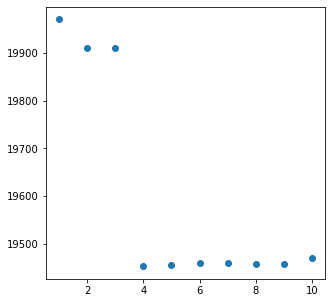

In [3]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
j = np.linspace(1,10,10)

ax.scatter(j, aic)
sort_ind = np.argsort(aic)
j_min = j[sort_ind[0]]
print(j_min)

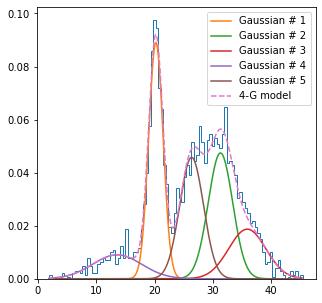

In [4]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.hist(data[:,0], bins=100, density=True, histtype = 'step')

g = []
for i in range(0,5):
    g.append(norm(loc=means[4][i], scale = (cov[4][i])**0.5))
            
    y_func = np.zeros([5, len(x_grid)])

for i in range(0,5):
    y_func[i] = g[i].pdf(x_grid)*weights[4][i]
    ax.plot(x_grid, y_func[i], label = 'Gaussian # %.0f' %(i+1))

ax.plot(x_grid, np.sum(y_func, axis=0), label = '4-G model', ls='--')
ax.legend()

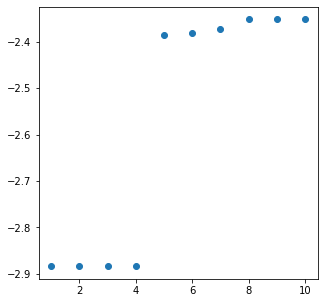

In [13]:
ln_L=[]
max_ln_L = []

for i in range(0, 10):
    ln_L.append(fit_g[i].score_samples(data))
    max_ln_L.append(np.max(ln_L))

fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(j, max_ln_L)